# Task2: Rate of Progression Classification - Classification Problem

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import re
import random
from IPython.display import display
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib inline
from sklearn.datasets import make_classification
from sklearn.utils import shuffle
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeClassifierCV, LassoCV
from sklearn.metrics import roc_auc_score, make_scorer, confusion_matrix, classification_report, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt 
from scipy import stats
from scipy.stats import norm, skew
import numpy as np
import pylab as pl
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV

# Import Data

In [2]:
train = pd.read_csv('pd_train.csv')
test = pd.read_csv('pd_test.csv')
train = train.drop('mds_updrs', axis=1)

In [3]:
print(train.head())
print('**'* 50)
print(test.head())

   patno  time_from_diag        age  sex  domside  educlvl    heightcm  \
0      1        2.939524  52.296057    1        2        5  167.780072   
1      2        3.269823  80.902888    1        3        5  167.062085   
2      3        5.058708  81.153534    1        3        5  180.920299   
3      4        3.570508  73.899619    1        1        5  168.524877   
4      5        3.629288  53.851122    2        3        4  162.408731   

    weightkg  systolic_bp  diastolic_bp     hrstnd  rtremor  rigidity  \
0  55.617368   117.809229     79.478457  69.335387        1         1   
1  71.046884   117.107318     75.126492  81.997693        1         1   
2  71.565611   122.504921     77.380747  79.391687        0         1   
3  70.942746   121.141740     81.200441  74.485401        0         1   
4  48.834373   123.308461     76.871725  70.881446        1         1   

   bradykinesia  gait       moca  modseadl  progression_rate  
0             1     0  26.838937        95           

In [4]:
print(train.info())
print('**'* 50)
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 18 columns):
patno               1500 non-null int64
time_from_diag      1500 non-null float64
age                 1500 non-null float64
sex                 1500 non-null int64
domside             1500 non-null int64
educlvl             1500 non-null int64
heightcm            1500 non-null float64
weightkg            1500 non-null float64
systolic_bp         1500 non-null float64
diastolic_bp        1500 non-null float64
hrstnd              1500 non-null float64
rtremor             1500 non-null int64
rigidity            1500 non-null int64
bradykinesia        1500 non-null int64
gait                1500 non-null int64
moca                1500 non-null float64
modseadl            1500 non-null int64
progression_rate    1500 non-null int64
dtypes: float64(8), int64(10)
memory usage: 211.1 KB
None
***************************************************************************************************

• patno: Patient identification number

• time_from_diag: Elapsed time from diagnosis, in years

• age: Age at diagnosis

• sex: Sex (1 = male, 2 = female)

• domside: Side predominantly affected at diagnosis (1 = right, 2 = left, 3 = symmetric)

• educlvl: Education level (1 = less than high school, 2 = high school, 3 = some college, 4 = undergraduate degree, 5 = graduate degree)

• heightcm: Height in centimeters at diagnosis

• weightkg: Weight in kilograms at diagnosis

• systolic_bp: Systolic blood pressure at diagnosis

• diastolic_bp: Diastolic blood pressure at diagnosis

• hrstnd: Standing heart rate at diagnosis

• rtremor: Resting tremor present at diagnosis

• rigidity: Rigidity present at diagnosis

• bradykinesia: Bradykinesia present at diagnosis

• gait: Gait disturbances present at diagnosis

• moca: Montreal Cognitive Assessment Score at diagnosis (lower scores indicate more severe symptoms)

• modseadl: Modified Schwab & England Activities of Daily Living Score at diagnosis (lower scores indicate more severe symptoms)

• mds_updrs: MDS-revised Unified Parkinson’s Disease Rating Scale (MDS-UPDRS) total score at time specified in time_from_diag (higher scores indicate more severe symptoms)

• progression_rate: Categorized rate of progression of Parkinson’s disease symptoms (1 = slow, 2 = moderate, 3 = fast, 4 = rapid)

# Data Visualization


 mu = 2.12 and sigma = 0.73



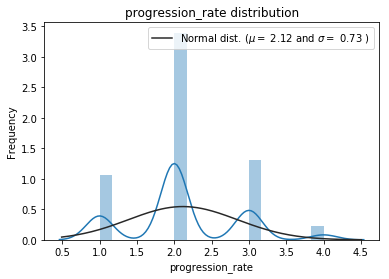

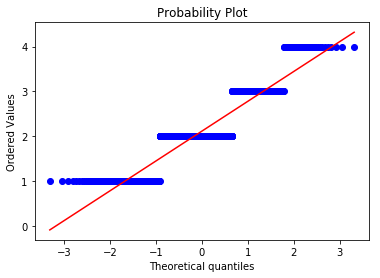

In [5]:
sns.distplot(train['progression_rate'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['progression_rate'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('progression_rate distribution')

fig = plt.figure()
res = stats.probplot(train['progression_rate'], plot=plt)
plt.show()

According to the distribution of target, we could know this is more likely a classification proble rather than a regression problem.

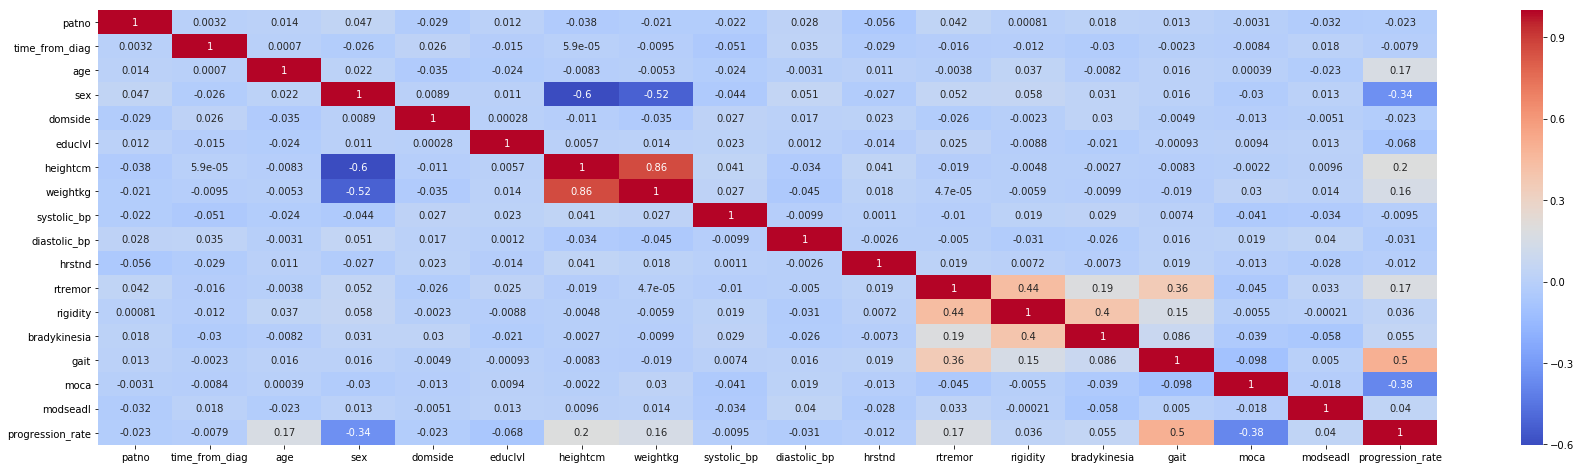

In [6]:
plt.figure(figsize=(30,8))
sns.heatmap(train.corr(),cmap='coolwarm',annot = True)
plt.show()

In [7]:
corr = train.corr()

In [8]:
corr[corr['progression_rate']>0.3].index

Index(['gait', 'progression_rate'], dtype='object')

Because the size of feature is only 16 and we should try to leverage features as more as possible in this situation, so I will not remove any feature and select features in this dataset.

# Feature Engineering

In [9]:
#missing data
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(25)

,Total,Percent
progression_rate,0,0.0
modseadl,0,0.0
time_from_diag,0,0.0
age,0,0.0
sex,0,0.0
domside,0,0.0
educlvl,0,0.0
heightcm,0,0.0
weightkg,0,0.0
systolic_bp,0,0.0


In [10]:
#missing data
total_test = test.isnull().sum().sort_values(ascending=False)
percent_test = (test.isnull().sum()/test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_test, percent_test], axis=1, keys=['Total', 'Percent'])
missing_data.head(25)

,Total,Percent
modseadl,0,0.0
weightkg,0,0.0
time_from_diag,0,0.0
age,0,0.0
sex,0,0.0
domside,0,0.0
educlvl,0,0.0
heightcm,0,0.0
systolic_bp,0,0.0
moca,0,0.0


In [11]:
#Frequency distribution of classes"
train_outcome = pd.crosstab(index=train["progression_rate"],  # Make a crosstab
                              columns="count")      # Name the count column
train_outcome

col_0,count
progression_rate,
1,267
2,849
3,328
4,56


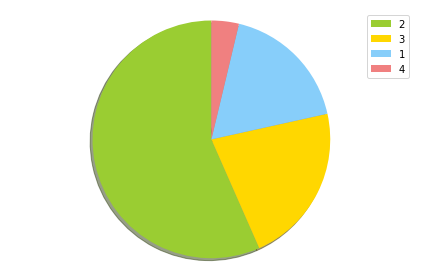

In [12]:
# Visualizing Outcome Distribution 
temp = train["progression_rate"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })

#df.plot(kind='pie',labels='labels',values='values', title='progression_rate Ditribution',subplots= "True")

labels = df['labels']
sizes = df['values']
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90, pctdistance=1.1, labeldistance=1.2)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()

# Build Machine Learning Models

Train Test Split 

Now let's split the data into a training set and a testing set. We will train out model on the training set and then use the test set to evaluate the model.

In [13]:
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(train.drop('progression_rate', axis=1), train.progression_rate.values.astype(object), test_size=0.3, random_state=101)
X_train, X_test, y_train, y_test = train_test_split(train.drop('progression_rate', axis=1), train['progression_rate'], test_size=0.3, random_state=101)

In [14]:
# Dimension of Train and Test set 
print("Dimension of Train set",X_train.shape)
print("Dimension of Test set",X_test.shape,"\n")

Dimension of Train set (1050, 17)
Dimension of Test set (450, 17) 



In [15]:
#Total Number of Continous and Categorical features in the training set
num_cols = X_train._get_numeric_data().columns
print("Number of numeric features:",num_cols.size)

Number of numeric features: 17


In [16]:
names_of_predictors = list(X_train.columns.values)
# Scaling the Train and Test feature set 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
X_train

array([[-0.06634091,  0.94747293, -1.59388628, ..., -0.34208373,
        -0.24439034, -0.95481123],
       [-0.57354215, -0.13380054,  1.51098418, ..., -0.34208373,
         0.83662776,  0.2855869 ],
       [-1.52309698, -0.74544534, -0.4248831 , ..., -0.34208373,
         0.62204509, -0.33461216],
       ...,
       [-0.36741927,  1.81903371, -0.30985739, ..., -0.34208373,
         1.04971191,  1.00915248],
       [ 1.39736313,  0.0731068 , -0.01842129, ..., -0.34208373,
         0.28199774,  0.38895342],
       [ 0.2440014 , -0.90072301,  0.10173095, ..., -0.34208373,
         0.79375201, -1.78174332]])

In [18]:
y_train

729     1
510     2
100     1
1054    2
1055    2
       ..
1417    1
75      3
599     1
1361    2
863     2
Name: progression_rate, Length: 1050, dtype: int64

# SVM

In [19]:
# Create the parameter grid based on the results of random search 
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

In [20]:
# Performing CV to tune parameters for best SVM fit 
svm_model = GridSearchCV(SVC(), params_grid, cv=5)
svm_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}])

In [21]:
# View the accuracy score
print('Best score for training data:', svm_model.best_score_,"\n") 
# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")
final_model = svm_model.best_estimator_
svm_pred = final_model.predict(X_test)

Best score for training data: 0.8161904761904761 

Best C: 1000 

Best Kernel: linear 

Best Gamma: scale 



In [22]:
# Making the Confusion Matrix
#print(pd.crosstab(Y_test_label, Y_pred_label, rownames=['Actual Activity'], colnames=['Predicted Activity']))
print(confusion_matrix(y_test, svm_pred))
print("\n")
print(classification_report(y_test, svm_pred))
print("Training set score for SVM: %f" % final_model.score(X_train, y_train))
print("Testing  set score for SVM: %f" % final_model.score(X_test, y_test ))
svm_model.score

[[ 56  20   3   0]
 [ 16 232   9   2]
 [ 13  20  60   2]
 [  1   0  15   1]]


              precision    recall  f1-score   support

           1       0.65      0.71      0.68        79
           2       0.85      0.90      0.87       259
           3       0.69      0.63      0.66        95
           4       0.20      0.06      0.09        17

    accuracy                           0.78       450
   macro avg       0.60      0.57      0.58       450
weighted avg       0.76      0.78      0.76       450

Training set score for SVM: 0.824762
Testing  set score for SVM: 0.775556


<bound method BaseSearchCV.score of GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}])>

# Decision Tree

In [23]:
from sklearn import tree
dtreg=tree.DecisionTreeClassifier(criterion="entropy")
dtreg.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

In [24]:
dtr_pred = dtreg.predict(X_test)

In [25]:
print(confusion_matrix(y_test, dtr_pred))
print("\n")
print(classification_report(y_test, dtr_pred))
print("Training set score for Decision Tree: %f" % dtreg.score(X_train, y_train))
print("Testing  set score for Decision Tree: %f" % dtreg.score(X_test, y_test))

[[ 60  18   1   0]
 [ 20 228  11   0]
 [  2  10  78   5]
 [  0   1   9   7]]


              precision    recall  f1-score   support

           1       0.73      0.76      0.75        79
           2       0.89      0.88      0.88       259
           3       0.79      0.82      0.80        95
           4       0.58      0.41      0.48        17

    accuracy                           0.83       450
   macro avg       0.75      0.72      0.73       450
weighted avg       0.83      0.83      0.83       450

Training set score for Decision Tree: 1.000000
Testing  set score for Decision Tree: 0.828889


# CatBoost

In [26]:
from catboost import Pool, CatBoostClassifier
train_pool = Pool(data=X_train, label=y_train)
test_pool = Pool(data=X_test, label=y_test.values) 

In [27]:
cbc = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    random_strength=0.1,
    depth=8,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    leaf_estimation_method='Newton'
)

In [28]:
cbc.fit(train_pool,plot=True,eval_set=test_pool)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8876190	test: 0.8533333	best: 0.8533333 (0)	total: 70.1ms	remaining: 1m 10s
1:	learn: 0.8942857	test: 0.8533333	best: 0.8533333 (0)	total: 91ms	remaining: 45.4s
2:	learn: 0.8885714	test: 0.8555556	best: 0.8555556 (2)	total: 110ms	remaining: 36.6s
3:	learn: 0.8904762	test: 0.8577778	best: 0.8577778 (3)	total: 130ms	remaining: 32.2s
4:	learn: 0.8933333	test: 0.8577778	best: 0.8577778 (3)	total: 149ms	remaining: 29.6s
5:	learn: 0.9000000	test: 0.8577778	best: 0.8577778 (3)	total: 167ms	remaining: 27.6s
6:	learn: 0.9028571	test: 0.8577778	best: 0.8577778 (3)	total: 185ms	remaining: 26.3s
7:	learn: 0.9057143	test: 0.8555556	best: 0.8577778 (3)	total: 203ms	remaining: 25.2s
8:	learn: 0.9057143	test: 0.8577778	best: 0.8577778 (3)	total: 222ms	remaining: 24.4s
9:	learn: 0.9057143	test: 0.8600000	best: 0.8600000 (9)	total: 241ms	remaining: 23.9s
10:	learn: 0.9057143	test: 0.8622222	best: 0.8622222 (10)	total: 261ms	remaining: 23.5s
11:	learn: 0.9066667	test: 0.8644444	best: 0.864444

98:	learn: 0.9695238	test: 0.8622222	best: 0.8777778 (23)	total: 1.95s	remaining: 17.8s
99:	learn: 0.9704762	test: 0.8644444	best: 0.8777778 (23)	total: 1.97s	remaining: 17.8s
100:	learn: 0.9695238	test: 0.8644444	best: 0.8777778 (23)	total: 2s	remaining: 17.8s
101:	learn: 0.9714286	test: 0.8622222	best: 0.8777778 (23)	total: 2.02s	remaining: 17.7s
102:	learn: 0.9714286	test: 0.8600000	best: 0.8777778 (23)	total: 2.03s	remaining: 17.7s
103:	learn: 0.9723810	test: 0.8555556	best: 0.8777778 (23)	total: 2.05s	remaining: 17.7s
104:	learn: 0.9723810	test: 0.8577778	best: 0.8777778 (23)	total: 2.07s	remaining: 17.6s
105:	learn: 0.9742857	test: 0.8555556	best: 0.8777778 (23)	total: 2.09s	remaining: 17.6s
106:	learn: 0.9733333	test: 0.8555556	best: 0.8777778 (23)	total: 2.11s	remaining: 17.6s
107:	learn: 0.9742857	test: 0.8600000	best: 0.8777778 (23)	total: 2.12s	remaining: 17.5s
108:	learn: 0.9733333	test: 0.8622222	best: 0.8777778 (23)	total: 2.14s	remaining: 17.5s
109:	learn: 0.9742857	test

198:	learn: 0.9961905	test: 0.8577778	best: 0.8777778 (23)	total: 3.79s	remaining: 15.3s
199:	learn: 0.9961905	test: 0.8555556	best: 0.8777778 (23)	total: 3.81s	remaining: 15.3s
200:	learn: 0.9961905	test: 0.8577778	best: 0.8777778 (23)	total: 3.83s	remaining: 15.2s
201:	learn: 0.9961905	test: 0.8555556	best: 0.8777778 (23)	total: 3.85s	remaining: 15.2s
202:	learn: 0.9961905	test: 0.8555556	best: 0.8777778 (23)	total: 3.87s	remaining: 15.2s
203:	learn: 0.9961905	test: 0.8555556	best: 0.8777778 (23)	total: 3.89s	remaining: 15.2s
204:	learn: 0.9961905	test: 0.8555556	best: 0.8777778 (23)	total: 3.91s	remaining: 15.1s
205:	learn: 0.9971429	test: 0.8555556	best: 0.8777778 (23)	total: 3.92s	remaining: 15.1s
206:	learn: 0.9971429	test: 0.8533333	best: 0.8777778 (23)	total: 3.94s	remaining: 15.1s
207:	learn: 0.9971429	test: 0.8533333	best: 0.8777778 (23)	total: 3.96s	remaining: 15.1s
208:	learn: 0.9971429	test: 0.8555556	best: 0.8777778 (23)	total: 3.98s	remaining: 15.1s
209:	learn: 0.9971429

297:	learn: 1.0000000	test: 0.8600000	best: 0.8777778 (23)	total: 5.65s	remaining: 13.3s
298:	learn: 1.0000000	test: 0.8577778	best: 0.8777778 (23)	total: 5.67s	remaining: 13.3s
299:	learn: 1.0000000	test: 0.8600000	best: 0.8777778 (23)	total: 5.69s	remaining: 13.3s
300:	learn: 1.0000000	test: 0.8555556	best: 0.8777778 (23)	total: 5.71s	remaining: 13.3s
301:	learn: 1.0000000	test: 0.8555556	best: 0.8777778 (23)	total: 5.72s	remaining: 13.2s
302:	learn: 1.0000000	test: 0.8555556	best: 0.8777778 (23)	total: 5.74s	remaining: 13.2s
303:	learn: 1.0000000	test: 0.8555556	best: 0.8777778 (23)	total: 5.76s	remaining: 13.2s
304:	learn: 1.0000000	test: 0.8577778	best: 0.8777778 (23)	total: 5.78s	remaining: 13.2s
305:	learn: 1.0000000	test: 0.8533333	best: 0.8777778 (23)	total: 5.8s	remaining: 13.1s
306:	learn: 1.0000000	test: 0.8533333	best: 0.8777778 (23)	total: 5.81s	remaining: 13.1s
307:	learn: 1.0000000	test: 0.8533333	best: 0.8777778 (23)	total: 5.83s	remaining: 13.1s
308:	learn: 1.0000000	

393:	learn: 1.0000000	test: 0.8488889	best: 0.8777778 (23)	total: 7.53s	remaining: 11.6s
394:	learn: 1.0000000	test: 0.8488889	best: 0.8777778 (23)	total: 7.55s	remaining: 11.6s
395:	learn: 1.0000000	test: 0.8488889	best: 0.8777778 (23)	total: 7.57s	remaining: 11.5s
396:	learn: 1.0000000	test: 0.8488889	best: 0.8777778 (23)	total: 7.59s	remaining: 11.5s
397:	learn: 1.0000000	test: 0.8488889	best: 0.8777778 (23)	total: 7.61s	remaining: 11.5s
398:	learn: 1.0000000	test: 0.8488889	best: 0.8777778 (23)	total: 7.63s	remaining: 11.5s
399:	learn: 1.0000000	test: 0.8488889	best: 0.8777778 (23)	total: 7.64s	remaining: 11.5s
400:	learn: 1.0000000	test: 0.8488889	best: 0.8777778 (23)	total: 7.66s	remaining: 11.4s
401:	learn: 1.0000000	test: 0.8511111	best: 0.8777778 (23)	total: 7.68s	remaining: 11.4s
402:	learn: 1.0000000	test: 0.8488889	best: 0.8777778 (23)	total: 7.7s	remaining: 11.4s
403:	learn: 1.0000000	test: 0.8511111	best: 0.8777778 (23)	total: 7.72s	remaining: 11.4s
404:	learn: 1.0000000	

486:	learn: 1.0000000	test: 0.8488889	best: 0.8777778 (23)	total: 9.43s	remaining: 9.94s
487:	learn: 1.0000000	test: 0.8488889	best: 0.8777778 (23)	total: 9.45s	remaining: 9.92s
488:	learn: 1.0000000	test: 0.8488889	best: 0.8777778 (23)	total: 9.48s	remaining: 9.9s
489:	learn: 1.0000000	test: 0.8511111	best: 0.8777778 (23)	total: 9.5s	remaining: 9.88s
490:	learn: 1.0000000	test: 0.8511111	best: 0.8777778 (23)	total: 9.52s	remaining: 9.87s
491:	learn: 1.0000000	test: 0.8488889	best: 0.8777778 (23)	total: 9.54s	remaining: 9.85s
492:	learn: 1.0000000	test: 0.8511111	best: 0.8777778 (23)	total: 9.56s	remaining: 9.83s
493:	learn: 1.0000000	test: 0.8511111	best: 0.8777778 (23)	total: 9.58s	remaining: 9.81s
494:	learn: 1.0000000	test: 0.8511111	best: 0.8777778 (23)	total: 9.59s	remaining: 9.79s
495:	learn: 1.0000000	test: 0.8511111	best: 0.8777778 (23)	total: 9.61s	remaining: 9.77s
496:	learn: 1.0000000	test: 0.8511111	best: 0.8777778 (23)	total: 9.63s	remaining: 9.75s
497:	learn: 1.0000000	t

580:	learn: 1.0000000	test: 0.8555556	best: 0.8777778 (23)	total: 11.4s	remaining: 8.22s
581:	learn: 1.0000000	test: 0.8533333	best: 0.8777778 (23)	total: 11.4s	remaining: 8.2s
582:	learn: 1.0000000	test: 0.8533333	best: 0.8777778 (23)	total: 11.4s	remaining: 8.19s
583:	learn: 1.0000000	test: 0.8533333	best: 0.8777778 (23)	total: 11.5s	remaining: 8.17s
584:	learn: 1.0000000	test: 0.8533333	best: 0.8777778 (23)	total: 11.5s	remaining: 8.15s
585:	learn: 1.0000000	test: 0.8555556	best: 0.8777778 (23)	total: 11.5s	remaining: 8.13s
586:	learn: 1.0000000	test: 0.8577778	best: 0.8777778 (23)	total: 11.5s	remaining: 8.11s
587:	learn: 1.0000000	test: 0.8577778	best: 0.8777778 (23)	total: 11.5s	remaining: 8.09s
588:	learn: 1.0000000	test: 0.8555556	best: 0.8777778 (23)	total: 11.6s	remaining: 8.07s
589:	learn: 1.0000000	test: 0.8555556	best: 0.8777778 (23)	total: 11.6s	remaining: 8.05s
590:	learn: 1.0000000	test: 0.8533333	best: 0.8777778 (23)	total: 11.6s	remaining: 8.03s
591:	learn: 1.0000000	

673:	learn: 1.0000000	test: 0.8533333	best: 0.8777778 (23)	total: 13.3s	remaining: 6.45s
674:	learn: 1.0000000	test: 0.8533333	best: 0.8777778 (23)	total: 13.4s	remaining: 6.43s
675:	learn: 1.0000000	test: 0.8533333	best: 0.8777778 (23)	total: 13.4s	remaining: 6.41s
676:	learn: 1.0000000	test: 0.8533333	best: 0.8777778 (23)	total: 13.4s	remaining: 6.39s
677:	learn: 1.0000000	test: 0.8533333	best: 0.8777778 (23)	total: 13.4s	remaining: 6.37s
678:	learn: 1.0000000	test: 0.8533333	best: 0.8777778 (23)	total: 13.4s	remaining: 6.35s
679:	learn: 1.0000000	test: 0.8533333	best: 0.8777778 (23)	total: 13.4s	remaining: 6.33s
680:	learn: 1.0000000	test: 0.8533333	best: 0.8777778 (23)	total: 13.5s	remaining: 6.31s
681:	learn: 1.0000000	test: 0.8533333	best: 0.8777778 (23)	total: 13.5s	remaining: 6.29s
682:	learn: 1.0000000	test: 0.8533333	best: 0.8777778 (23)	total: 13.5s	remaining: 6.27s
683:	learn: 1.0000000	test: 0.8533333	best: 0.8777778 (23)	total: 13.5s	remaining: 6.25s
684:	learn: 1.0000000

773:	learn: 1.0000000	test: 0.8533333	best: 0.8777778 (23)	total: 15.4s	remaining: 4.5s
774:	learn: 1.0000000	test: 0.8533333	best: 0.8777778 (23)	total: 15.4s	remaining: 4.47s
775:	learn: 1.0000000	test: 0.8533333	best: 0.8777778 (23)	total: 15.4s	remaining: 4.46s
776:	learn: 1.0000000	test: 0.8533333	best: 0.8777778 (23)	total: 15.5s	remaining: 4.44s
777:	learn: 1.0000000	test: 0.8533333	best: 0.8777778 (23)	total: 15.5s	remaining: 4.42s
778:	learn: 1.0000000	test: 0.8533333	best: 0.8777778 (23)	total: 15.5s	remaining: 4.4s
779:	learn: 1.0000000	test: 0.8533333	best: 0.8777778 (23)	total: 15.5s	remaining: 4.38s
780:	learn: 1.0000000	test: 0.8533333	best: 0.8777778 (23)	total: 15.6s	remaining: 4.36s
781:	learn: 1.0000000	test: 0.8533333	best: 0.8777778 (23)	total: 15.6s	remaining: 4.34s
782:	learn: 1.0000000	test: 0.8533333	best: 0.8777778 (23)	total: 15.6s	remaining: 4.32s
783:	learn: 1.0000000	test: 0.8533333	best: 0.8777778 (23)	total: 15.6s	remaining: 4.3s
784:	learn: 1.0000000	te

868:	learn: 1.0000000	test: 0.8533333	best: 0.8777778 (23)	total: 17.4s	remaining: 2.62s
869:	learn: 1.0000000	test: 0.8533333	best: 0.8777778 (23)	total: 17.4s	remaining: 2.6s
870:	learn: 1.0000000	test: 0.8533333	best: 0.8777778 (23)	total: 17.4s	remaining: 2.58s
871:	learn: 1.0000000	test: 0.8533333	best: 0.8777778 (23)	total: 17.4s	remaining: 2.56s
872:	learn: 1.0000000	test: 0.8533333	best: 0.8777778 (23)	total: 17.4s	remaining: 2.54s
873:	learn: 1.0000000	test: 0.8533333	best: 0.8777778 (23)	total: 17.5s	remaining: 2.52s
874:	learn: 1.0000000	test: 0.8533333	best: 0.8777778 (23)	total: 17.5s	remaining: 2.5s
875:	learn: 1.0000000	test: 0.8533333	best: 0.8777778 (23)	total: 17.5s	remaining: 2.48s
876:	learn: 1.0000000	test: 0.8533333	best: 0.8777778 (23)	total: 17.5s	remaining: 2.46s
877:	learn: 1.0000000	test: 0.8533333	best: 0.8777778 (23)	total: 17.5s	remaining: 2.44s
878:	learn: 1.0000000	test: 0.8533333	best: 0.8777778 (23)	total: 17.6s	remaining: 2.42s
879:	learn: 1.0000000	t

967:	learn: 1.0000000	test: 0.8533333	best: 0.8777778 (23)	total: 19.5s	remaining: 644ms
968:	learn: 1.0000000	test: 0.8555556	best: 0.8777778 (23)	total: 19.5s	remaining: 624ms
969:	learn: 1.0000000	test: 0.8555556	best: 0.8777778 (23)	total: 19.5s	remaining: 604ms
970:	learn: 1.0000000	test: 0.8555556	best: 0.8777778 (23)	total: 19.5s	remaining: 583ms
971:	learn: 1.0000000	test: 0.8533333	best: 0.8777778 (23)	total: 19.6s	remaining: 563ms
972:	learn: 1.0000000	test: 0.8555556	best: 0.8777778 (23)	total: 19.6s	remaining: 543ms
973:	learn: 1.0000000	test: 0.8533333	best: 0.8777778 (23)	total: 19.6s	remaining: 523ms
974:	learn: 1.0000000	test: 0.8533333	best: 0.8777778 (23)	total: 19.6s	remaining: 503ms
975:	learn: 1.0000000	test: 0.8533333	best: 0.8777778 (23)	total: 19.6s	remaining: 483ms
976:	learn: 1.0000000	test: 0.8555556	best: 0.8777778 (23)	total: 19.7s	remaining: 463ms
977:	learn: 1.0000000	test: 0.8533333	best: 0.8777778 (23)	total: 19.7s	remaining: 443ms
978:	learn: 1.0000000

In [29]:
print("Training set score for CatBoostClassifiere: %f" % cbc.score(X_train, y_train))
print("Testing  set score for CatBoostClassifier: %f" % cbc.score(X_test, y_test))

Training set score for CatBoostClassifiere: 0.910476
Testing  set score for CatBoostClassifier: 0.877778


# Model Comparison
By comparing accuracy score of training and testing sets both, we could know CatBoost performs best among these models.

# Predict on Test Data 

In [30]:
a = pd.read_csv('pd_test.csv')

In [31]:
test_id = a['patno']
a = pd.DataFrame(test_id, columns=['patno'])

In [32]:
test = scaler.fit_transform(test)

In [33]:
test.shape

(500, 17)

In [34]:
test_prediction_cbc = cbc.predict(test)

In [35]:
test_prediction_cbc

array([[2],
       [2],
       [3],
       [2],
       [2],
       [2],
       [2],
       [2],
       [3],
       [2],
       [3],
       [3],
       [2],
       [1],
       [1],
       [2],
       [1],
       [2],
       [3],
       [2],
       [1],
       [2],
       [3],
       [1],
       [2],
       [2],
       [2],
       [3],
       [2],
       [1],
       [2],
       [3],
       [1],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [1],
       [3],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [1],
       [1],
       [2],
       [1],
       [2],
       [1],
       [3],
       [2],
       [3],
       [2],
       [1],
       [1],
       [2],
       [3],
       [1],
       [2],
       [2],
       [3],
       [3],
       [2],
       [1],
       [2],
       [2],
       [2],
       [2],
       [1],
       [2],
       [2],
       [2],
       [1],
       [1],
       [2],
       [1],
       [2],
       [1],
       [2],
    

In [36]:
test_prediction_cbc = pd.DataFrame(test_prediction_cbc, columns=['progression_rate'])

In [37]:
test_prediction_cbc.head()

,progression_rate
0,2
1,2
2,3
3,2
4,2


In [38]:
result = pd.concat([a,test_prediction_cbc], axis=1)

In [39]:
result.head()

,patno,progression_rate
0,1501,2
1,1502,2
2,1503,3
3,1504,2
4,1505,2


In [40]:
result.to_csv('ProgressionRate.csv',index=False)